## Imports

In [8]:
# data and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# built in
import os
import glob
import itertools
import time

# displays
from IPython.display import display, clear_output

# machine learning and regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Outline
Building a random forest to predict aerobe / anaerobe classes

### Loading data

In [3]:
# load gtdb data
gtdb_md = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv', sep='\t', index_col=0)
# gtdb_md = gtdb_md[gtdb_md.gtdb_representative.eq('t')]

Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
# data of anaerobe / aerobe labels
bacdive_data = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/data/advsearch_bacdive_2022-06-09.csv', skiprows=1)

In [5]:
oxygen_tolerance_mapping = {
'aerobe':'aerobe', 'anaerobe':'anaerobe',
'microaerophile':'anaerobe',
'facultative anaerobe':'aerobe', 'obligate aerobe':'aerobe',
'obligate anaerobe':'anaerobe', 'facultative aerobe':'anaerobe',
'aerotolerant':'anaerobe', 'microaerotolerant':'anaerobe'
}

# print out counts for classes
bacdive_data['Oxygen tolerance'].fillna('none').value_counts()

aerobe                  4296
anaerobe                2073
microaerophile           992
facultative anaerobe     756
none                     741
obligate aerobe          206
obligate anaerobe        145
facultative aerobe        80
aerotolerant               8
microaerotolerant          3
Name: Oxygen tolerance, dtype: int64

In [6]:
bacdive_cat_summaries = bacdive_data['Oxygen tolerance'].fillna('none').value_counts()
bacdive_cat_summaries / bacdive_cat_summaries.sum()

aerobe                  0.461935
anaerobe                0.222903
microaerophile          0.106667
facultative anaerobe    0.081290
none                    0.079677
obligate aerobe         0.022151
obligate anaerobe       0.015591
facultative aerobe      0.008602
aerotolerant            0.000860
microaerotolerant       0.000323
Name: Oxygen tolerance, dtype: float64

In [10]:
bacdive_data['oxygen_tolerance_reformat'] = bacdive_data['Oxygen tolerance'].map(oxygen_tolerance_mapping)

In [11]:
# fix a multi-row data formatting problem
new_rows = []
for index, row in bacdive_data.iterrows():
    # print([row['ID']])
    if np.isnan(row['ID']):
        new_rows.append(curr_row)
    else:
        new_rows.append(row)
        curr_ind = index
        curr_row = row.copy(deep=True)
        

In [12]:
bacdive_data_reformat = pd.concat(new_rows, axis=1).T.reset_index(drop=True)
bacdive_data_reformat['Genome Sequence associated NCBI tax ID'] = bacdive_data['Genome Sequence associated NCBI tax ID'].fillna(bacdive_data_reformat['Genome Sequence associated NCBI tax ID'])
bacdive_data_reformat['Oxygen tolerance'] = bacdive_data['Oxygen tolerance'].fillna(bacdive_data_reformat['Oxygen tolerance'])

In [13]:
bacdive_data_reformat['Genome Sequence associated NCBI tax ID'] = bacdive_data_reformat['Genome Sequence associated NCBI tax ID'].astype(int)

In [14]:
bacdive_data_reformat = bacdive_data_reformat[~bacdive_data_reformat['Oxygen tolerance'].fillna('none').eq('none')].copy(deep=True)

In [15]:
bacdive_data_reformat.shape

(9298, 8)

Retrieving mapping of assembly to taxon IDs so that BacDive taxon IDs with labels (aerobe, anaerobe) can be matched to their best representative genome assembly, and corresponding GTDB entry
```bash
wget ftp://ftp.ncbi.nlm.nih.gov/genomes/genbank/assembly_summary_genbank.txt
```

In [16]:
# load assembly data
assembly_summary_genbank = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/data/assembly_summary_genbank.txt', skiprows=1, sep='\t')
bacdive_assembly_summary = assembly_summary_genbank[assembly_summary_genbank['taxid'].isin(bacdive_data_reformat['Genome Sequence associated NCBI tax ID'])]

In [17]:
# list to hold selected genomes
taxon_gtdb_genomes = []

for index, row in bacdive_data_reformat.iterrows():

    if index % 100 == 0:
        display(index)
        clear_output(wait=True)
        
    # get assemblies for taxon id
    assemblies = bacdive_assembly_summary[bacdive_assembly_summary.taxid.eq(row['Genome Sequence associated NCBI tax ID'])]
    
    # if there are representatives, pick them
    if assemblies['refseq_category'].str.contains('genome').sum() >= 1:
        accessions = assemblies[assemblies['refseq_category'].str.contains('genome')]['# assembly_accession']
    else:
        accessions = assemblies['# assembly_accession']
    
    # subset GTDB to GTDB genomes in list of assemblies
    gtdb_subset = gtdb_md[gtdb_md.ncbi_genbank_assembly_accession.isin(accessions)]
    if len(gtdb_subset) > 0:
        # get gtdb genomes for each accession set, pick the highest quality, preferring representatives
        gtdb_genome = gtdb_subset.sort_values(['gtdb_representative', 'checkm_completeness', 'checkm_contamination'], ascending=[False, False, True]).index[0]
    else:
        gtdb_genome = ''
        
    taxon_gtdb_genomes.append(gtdb_genome)
        
    

9200

In [18]:
# add as column
bacdive_data_reformat['gtdb_matched_genome'] = taxon_gtdb_genomes
# remove rows where a gtdb representative couldn't be found
bacdive_data_reformat = bacdive_data_reformat[~bacdive_data_reformat.gtdb_matched_genome.eq('')]

In [19]:
# add the gtdb representative
bacdive_data_reformat['gtdb_representative_genome'] = gtdb_md.loc[bacdive_data_reformat['gtdb_matched_genome'],  'gtdb_genome_representative'].values

### Construct the response data

In [20]:
response_data_ungrouped = bacdive_data_reformat[['species', 'gtdb_matched_genome', 'gtdb_representative_genome', 'Oxygen tolerance']]

In [21]:
response_data_ungrouped.head()

,species,gtdb_matched_genome,gtdb_representative_genome,Oxygen tolerance
0,Abiotrophia defectiva,RS_GCF_013267415.1,RS_GCF_000160075.2,anaerobe
1,Abiotrophia defectiva,RS_GCF_000160075.2,RS_GCF_000160075.2,anaerobe
2,Abyssibacter profundi,RS_GCF_003151135.1,RS_GCF_003151135.1,aerobe
3,Abyssivirga alkaniphila,RS_GCF_018141425.1,RS_GCF_018141425.1,obligate anaerobe
4,Acanthopleuribacter pedis,RS_GCF_017377855.1,RS_GCF_017377855.1,aerobe


In [28]:
response_data_grouped.shape

(6626, 3)

In [22]:
# select most common annotation for each genome
response_data_grouped = response_data_ungrouped.groupby('gtdb_representative_genome').apply(lambda x: x['Oxygen tolerance'].value_counts().index[0]).reset_index()
response_data_grouped.columns = ['genome', 'oxygen_tolerance']

In [23]:
response_data_grouped['mapped_oxygen_tolerance'] = response_data_grouped['oxygen_tolerance'].map(oxygen_tolerance_mapping)

### Construct the predictor data

### Loading pfam data

In [20]:
%%time
all_pfam_data = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/gtdb_genomes_reps_r207_pfam_trusted.tsv.gz', sep='\t', compression='gzip', index_col=0)

CPU times: user 8min 30s, sys: 16.8 s, total: 8min 46s
Wall time: 8min 47s


### Make pfam data for all available genomes

In [21]:
predictor_df = all_pfam_data.reindex(response_data_grouped['genome'])

In [22]:
predictor_df.shape

(6626, 17422)

In [24]:
predictor_df.head()

,PF02826,PF00198,PF08975,PF01073,PF02829,PF02737,PF03061,PF17837,PF01812,PF01367,...,PF04521,PF18282,PF00865,PF18777,PF15075,PF15129,PF11505,PF12342,PF17673,PF10906
genome,,,,,,,,,,,,,,,,,,,,,
GB_GCA_000007325.1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GB_GCA_000010565.1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GB_GCA_000017245.1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GB_GCA_000018565.1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GB_GCA_000020605.1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
response_data_grouped.head()

,genome,oxygen_tolerance,mapped_oxygen_tolerance
0,GB_GCA_000007325.1,anaerobe,anaerobe
1,GB_GCA_000010565.1,anaerobe,anaerobe
2,GB_GCA_000017245.1,aerobe,aerobe
3,GB_GCA_000018565.1,aerobe,aerobe
4,GB_GCA_000020605.1,anaerobe,anaerobe


### Split out final validation dataset
Here, I am splitting out a dataset which will not be used in any decisions - purely a "final" test dataset.

In [27]:
X_final_test, X_train, y_final_test, y_train = train_test_split(predictor_df, response_data_grouped.set_index('genome')['mapped_oxygen_tolerance'], test_size=0.90, 
                                                                random_state=143)

In [31]:
X_final_test.shape, X_train.shape, y_final_test.shape, y_train.shape, predictor_df.shape

((662, 17422), (5964, 17422), (662,), (5964,), (6626, 17422))

## Modeling - Logistic regression

In [32]:
logistic_accuracies = []

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=143)

In [40]:
len(out_fold)

4772

In [41]:
# test 10 values for lambda parameter
for i, c in enumerate([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]):
    
    # use 5-fold cross validation
    display(c, i)
    clear_output(wait=True)
    # split data
    fold = 0
    for in_fold, out_fold in kfold.split(X_train, y_train):
        print('in', in_fold.shape, 'out', out_fold.shape)
        X_cv_out, y_cv_out = X_train.iloc[out_fold], y_train.iloc[out_fold]
        X_cv_in, y_cv_in = X_train.iloc[in_fold], y_train.iloc[in_fold]

        # logistic regression with L1 penalty
        log = LogisticRegression(penalty='l1', solver='liblinear')

        # fit
        log.fit(X_cv_in.values, y_cv_in.values)

        # calculate accuracies
        train_accuracy = (log.predict(X_cv_out.values) == y_cv_out.values).sum() / len(y_cv_out)
        logistic_accuracies.append(pd.Series(index=['lambda', 'fold', 'accuracy', '# nonzero coefficients'],
                                             data=[c, fold, train_accuracy, (log.coef_ > 0).sum()]))
        fold += 1
    


in (4771,) out (1193,)
in (4771,) out (1193,)
in (4771,) out (1193,)
in (4771,) out (1193,)
in (4772,) out (1192,)


In [42]:
logistic_accuracy_plotdf = pd.concat(logistic_accuracies, axis=1).T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Logistic Regression Accuracy')

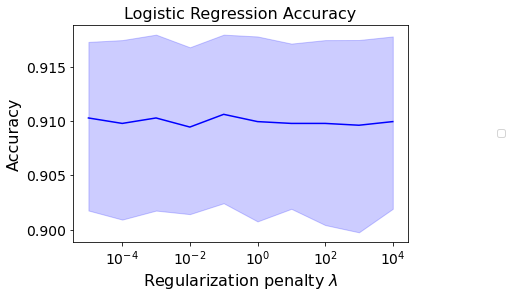

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=logistic_accuracy_plotdf, x='lambda', y='accuracy', color='b')
# sns.lineplot(data=logistic_accuracy_plotdf, x='lambda', y='test_accuracy', color='r')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
ax.set_xscale('log')
plt.tick_params(labelsize=14)
ax.set_xlabel('Regularization penalty $\lambda$', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('Logistic Regression Accuracy', fontsize=16)

#### Notes
The model does not appear to be very sensitive to the regularization parameter. I am going to pick a parameter of 1.

### Selecting significant features
We will perform this using the lambda parameter suggested by CV, 1, and all of the data with mapped values (edge cases included). To control for covariance among features, we will select features which have nonzero coefficients in models fitted with multiple repeated bootstraps, and optimize the number of bootstraps with nonzero coefficient in the parameter tuning process.

In [52]:
# construct a dataframe containing the 
n = len(X_train)
coefficient_list = []
for i in range(100):
    bootstrapped_response = y_train.sample(n=n, replace=True)
    bootstrapped_predictor = X_train.reindex(bootstrapped_response.index)
    display(i)
    clear_output(wait=True)

    log = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=1573)
    log.fit(bootstrapped_predictor.values, bootstrapped_response.values)
    coefficient_list.append(log.coef_)

99

In [53]:
coefficient_df = pd.concat([pd.Series(index=all_pfam_data.columns, data=c[0]) for c in coefficient_list], 1).T

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


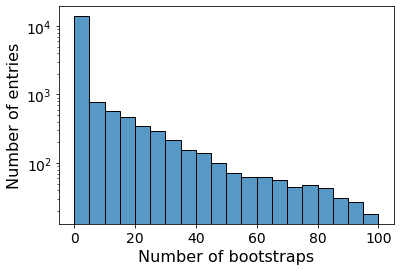

In [54]:
fig,ax = plt.subplots(figsize=(6,4))
sns.histplot((coefficient_df != 0).sum(), bins=20)
plt.tick_params(labelsize=14)
ax.set_ylabel('Number of entries', fontsize=16)
ax.set_xlabel('Number of bootstraps', fontsize=16)
ax.set_yscale('log')

## Modeling - random forest
My approach is to do a first pass of GridSearchCV which includes different numbers of proteins to include in the model as well as hyperparameters, then do a second nested cross-validation on narrower ranges of parameters to select the final model.

In [65]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 3000, num = 5)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 4)]
# Minimum number of samples required to split a node
min_samples_split = [2, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
all_cv_plotdfs = []
# testing different numbers of features
for cutoff in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    
    selected_predictors = coefficient_df.columns[(coefficient_df != 0).sum() >= cutoff]
    
    rf = RandomForestClassifier(random_state=458)
    # also testing combinations of parameters
    grid_rf = GridSearchCV(estimator = rf, param_grid = random_grid, cv=5, verbose=1, n_jobs=24, scoring='accuracy')

    grid_rf.fit(X_train.reindex(columns=selected_predictors).values, y_train.values)
    
    plotdf = pd.DataFrame(grid_rf.cv_results_).assign(cutoff=cutoff)
    
    all_cv_plotdfs.append(plotdf)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [68]:
all_cv_plotdf = pd.concat(all_cv_plotdfs)

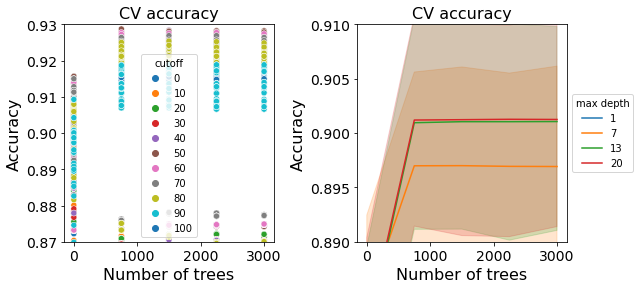

In [69]:
# initial figure to get a sense of parameter ranges
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(data=all_cv_plotdf.reset_index(drop=True), x='param_n_estimators', y='mean_test_score', hue='cutoff', palette='tab10')

ax.set_xlabel('Number of trees', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('CV accuracy', fontsize=16)
plt.tick_params(labelsize=14)
ax.set_ylim(0.87, 0.93)

ax = fig.add_subplot(1,2,2)
sns.lineplot(data=all_cv_plotdf.reset_index(drop=True), x='param_n_estimators', y='mean_test_score', hue='param_max_depth', palette='tab10')

lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='max depth')

ax.set_ylim(0.89, 0.91)

ax.set_xlabel('Number of trees', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('CV accuracy', fontsize=16)
plt.tick_params(labelsize=14)

fig.subplots_adjust(wspace=0.4)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/oxygen_cv_error.png', bbox_inches='tight', dpi=400, bbox_extra_artists=(lgd,))

#### Notes
The test accuracy does not seem to be significantly lower for optimal-ish parameters. I am going to visualize the different cutoff values and see which yields the best performance.

In [70]:
all_cv_plotdf['max_plus_bootstrap'] = all_cv_plotdf.apply(lambda row: row['param_max_features'] + ', ' + str(row['param_bootstrap']), axis=1)

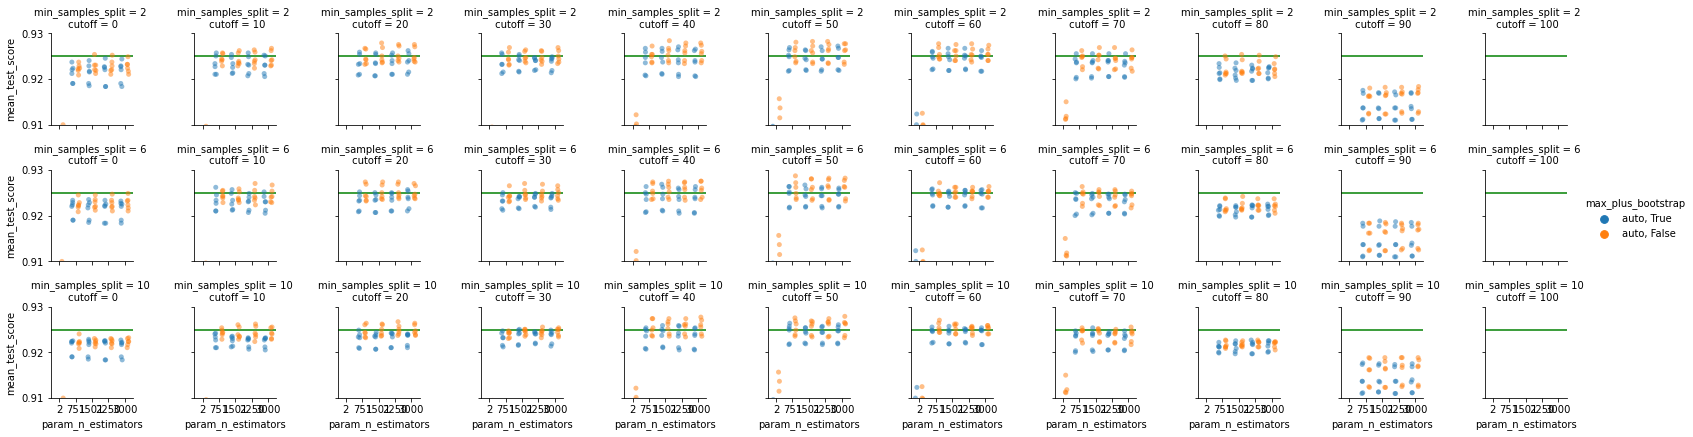

In [73]:
# more specific figure to get a sense of performance across combinations of parameters
g = sns.catplot(data=all_cv_plotdf[all_cv_plotdf.param_max_depth.isin([13, 20]) #& 
                     #all_cv_plotdf.param_min_samples_leaf.eq(1)
                                  ],
            kind='strip',
            x='param_n_estimators', 
            y='mean_test_score', 
            col='cutoff',
            hue='max_plus_bootstrap',
            row='param_min_samples_split', 
            height=2,
            **{'alpha':0.5, 'dodge':True})

# some formatting
for row in g.axes:
    for item in row:
        item.set_title(item.get_title().replace('|', '\n').replace('param_', ''), fontsize=10)
        item.axhline(0.925, color='g', zorder=0)
g.axes[0, 0].set_ylim(0.91, 0.93)
g.fig.subplots_adjust(wspace=0.75, hspace=0.5)

### Examining narrower parameter ranges for the optimal model with nested CV

In [1]:
# Number of trees in random forest
n_estimators = [600, 1000, 2000, 3000]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [13, 15, 17, 19, 21]
# Minimum number of samples required to split a node
min_samples_split = [2, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True, False]
cutoffs = [50, 60, 70]



In [96]:
# X_train, X_test, y_train, y_test = train_test_split(predictor_df.reindex(columns=selected_predictors), response_data_grouped, train_size=0.90)

cv_test_errors = []
outer_test_errors = []
parameter_combinations = list(itertools.product(n_estimators,
                                                         max_features,
                                                         max_depth,
                                                         min_samples_split,
                                                         min_samples_leaf,
                                                         bootstrap, 
                                                         cutoffs))
n_repetitions = 10
n_cv = 5
counter = 1

# for each parameter combination
for parameter_index, (est, maxf, maxd, mss, msl, b, c) in enumerate(parameter_combinations):
    
    # split into training and testing for model assessment
    repetition = 1
    outer_kfold = KFold(n_splits=n_repetitions, shuffle=True, random_state=119)
    for in_fold, out_fold in outer_kfold.split(X_train, y_train):
        
        # outer
        X_outer_out, y_outer_out = X_train.iloc[out_fold], y_train.iloc[out_fold]
        X_outer_in, y_outer_in = X_train.iloc[in_fold], y_train.iloc[in_fold]
        
        # select subset of Pfams as hyperparameter
        selected_predictors = coefficient_df.columns[(coefficient_df != 0).sum() >= c]

        
        # split into training and testing for model assessment
        inner_kfold = KFold(n_splits=n_cv, shuffle=True, random_state=245)
    
        # outer rf: model selection
        outer_rf = RandomForestClassifier(n_estimators=est, max_features=maxf, max_depth=maxd, min_samples_split=mss,
                                    min_samples_leaf=msl, bootstrap=b, n_jobs=24, random_state=5501)

        outer_rf.fit(X_outer_in.reindex(columns=selected_predictors).values, y_outer_in.values)

        test_accuracy = (outer_rf.predict(X_outer_out.reindex(columns=selected_predictors).values) == y_outer_out.values).sum() / len(y_outer_out)
    
        # perform CV for parameter selection
        cv = 1
        for in_fold_2, out_fold_2 in inner_kfold.split(X_outer_in, y_outer_in):
            # folds
            X_inner_out, y_inner_out = X_outer_in.iloc[out_fold_2], y_outer_in.iloc[out_fold_2]
            X_inner_in, y_inner_in = X_outer_in.iloc[in_fold_2], y_outer_in.iloc[in_fold_2]

            # model with parameters
            rf = RandomForestClassifier(n_estimators=est, max_features=maxf, max_depth=maxd, min_samples_split=mss,
                                        min_samples_leaf=msl, bootstrap=b, n_jobs=24, random_state=1234)

            rf.fit(X_inner_in.reindex(columns=selected_predictors).values, y_inner_in.values)
            
            cv_accuracy = (rf.predict(X_inner_out.reindex(columns=selected_predictors).values) == y_inner_out.values).sum() / len(y_inner_out)

            test_errors.append((test_accuracy, cv_accuracy, est, maxf, maxd, mss, msl, b, c, cv, parameter_index, repetition))
            
            percent_complete = counter / (len(parameter_combinations) * n_repetitions * n_cv) * 100
            display(f'{percent_complete:.2f}% complete')
            counter += 1
            cv += 1
            clear_output(wait=True)

        repetition += 1

'100.00% complete'

In [97]:
# make into dataframe
overfitting_test = pd.DataFrame(test_errors, columns=['test', 'cv', 
                                                      'n_estimators', 'max_features', 'max_depth', 
                                                      'min_samples_split', 'min_samples_leaf', 'bootstrap', 
                                                      'cutoff', 'cv_rep', 'parameter_set', 'outer_rep'])

In [98]:
overfitting_test.head(10)

,test,cv,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,cutoff,cv_rep,parameter_set,outer_rep
0,0.926298,0.926443,600,auto,13,2,1,True,50,1,0,1
1,0.926298,0.925512,600,auto,13,2,1,True,50,2,0,1
2,0.926298,0.929171,600,auto,13,2,1,True,50,3,0,1
3,0.926298,0.918919,600,auto,13,2,1,True,50,4,0,1
4,0.926298,0.910531,600,auto,13,2,1,True,50,5,0,1
5,0.936348,0.914339,600,auto,13,2,1,True,50,1,0,2
6,0.936348,0.930168,600,auto,13,2,1,True,50,2,0,2
7,0.936348,0.925443,600,auto,13,2,1,True,50,3,0,2
8,0.936348,0.926375,600,auto,13,2,1,True,50,4,0,2
9,0.936348,0.929171,600,auto,13,2,1,True,50,5,0,2


In [99]:
overfitting_test.to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/oxygen_tolerance_final_training_results.tsv.gz',
                        sep='\t', 
                        compression='gzip')

In [164]:
# some formatting for plot
overfitting_test_means = overfitting_test.groupby('parameter_set').mean().reset_index()

overfitting_test_means['n_est plus max_d'] = overfitting_test_means.apply(lambda row: f"{row['n_estimators']}, {row['max_depth']}", axis=1)

mapped_combined_columns = dict((e,i) for i,e in enumerate(overfitting_test_means['n_est plus max_d'].unique()))
mapped_combined_columns_reverse = dict((i,e) for i,e in enumerate(overfitting_test_means['n_est plus max_d'].unique()))
overfitting_test_means['n_est plus max_d mapped'] = overfitting_test_means['n_est plus max_d'].map(mapped_combined_columns)

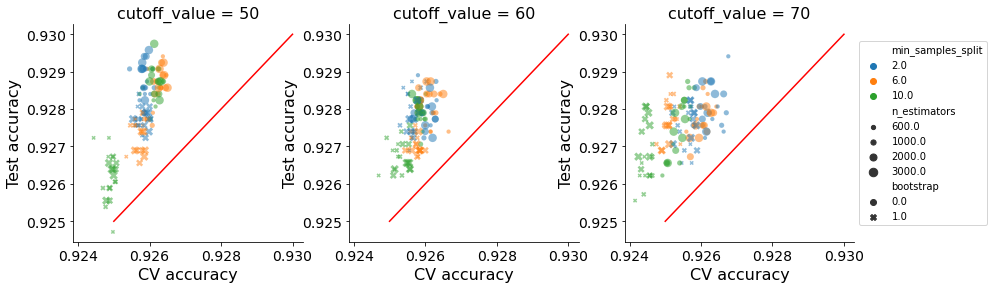

In [177]:
# plot of combinations of parameters
fig = plt.figure(figsize=(14, 4))
plot_count = 0
axes = []
for cutoff_value in [50, 60, 70]:
    if plot_count > 0:
        ax = fig.add_subplot(1,3,plot_count+1, sharey=axes[plot_count-1], sharex=axes[plot_count-1])
        axes.append(ax)
    else:
        ax = fig.add_subplot(1,3, plot_count+1)
        axes.append(ax)
        
    sns.scatterplot(data=overfitting_test_means[overfitting_test_means.cutoff.eq(cutoff_value)], x='cv', y='test',
                    hue='min_samples_split', palette='tab10', size='n_estimators', style='bootstrap' ,
                    alpha=0.5, linewidth=0)
    sns.despine()
    plt.plot((0.925, 0.93), (0.925, 0.93), color='r', zorder=0)
    if plot_count == 2:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.get_legend().remove()
        
    plt.tick_params(labelsize=14)
    ax.set_title(f'cutoff_value = {cutoff_value}', fontsize=16)
    ax.set_ylabel('Test accuracy', fontsize=16)
    ax.set_xlabel('CV accuracy', fontsize=16)
    plot_count += 1

#### Notes
There is a negligible difference between CV and test accuracy: < 0.01 in most cases. It looks like MSS = 2, n_est >= 2000, bootstrap = False, cutoff = 50 yields the highest test accuracy.

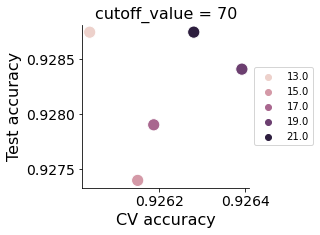

In [217]:
fig, ax = plt.subplots(figsize=(3, 3))
subset = overfitting_test_means[overfitting_test_means.min_samples_split.eq(2) &
                       overfitting_test_means.bootstrap.eq(False) &
                       overfitting_test_means.n_estimators.eq(3000) & 
                       overfitting_test_means.cutoff.eq(70)]

sns.scatterplot(data=subset, x='cv', y='test', hue='max_depth', s=150)
sns.despine()
plt.tick_params(labelsize=14)
ax.set_title(f'cutoff_value = 70', fontsize=16)
ax.set_ylabel('Test accuracy', fontsize=16)
ax.set_xlabel('CV accuracy', fontsize=16)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Notes
picking a max depth of 13

In [215]:
# select subset of Pfams
final_selected_predictors = coefficient_df.columns[(coefficient_df != 0).sum() >= 70]

final_rf = RandomForestClassifier(n_estimators=3000, max_features=maxf, max_depth=13, min_samples_split=2,
                            min_samples_leaf=1, bootstrap=False, n_jobs=24, random_state=562)

final_rf.fit(X_train.reindex(columns=final_selected_predictors).values, y_train.values)

RandomForestClassifier(bootstrap=False, max_depth=13, n_estimators=3000,
                       n_jobs=24, random_state=562)

In [216]:
(final_rf.predict(X_final_test.reindex(columns=final_selected_predictors).values) == y_final_test.values).sum() / len(y_final_test)

0.9138972809667674

## Done

In [6]:
import pickle

In [221]:
# saving data for reproducibility
coefficient_df.to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_coefficient_df.tsv.gz',
          sep='\t', compression='gzip')

with open('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_coefficient_list.txt', 'w') as list_handle:
    list_handle.write('\n'.join([s for s in final_selected_predictors]))
    
with open('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_RF_model.pickle', 'wb') as model_handle:
    pickle.dump(final_rf, model_handle)
    
y_train.to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_training_labels.tsv.gz',
               sep='\t', compression='gzip')
                      
y_final_test.to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_testing_labels.tsv.gz',
               sep='\t', compression='gzip')
                    

### Producing predictions for GTDB genomes

In [224]:
full_gtdb_predictions = final_rf.predict_proba(all_pfam_data.reindex(columns=final_selected_predictors).values)

In [231]:
pd.DataFrame(index=all_pfam_data.index, data=full_gtdb_predictions, columns=final_rf.classes_).to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_oxygen_predictions.tsv.gz',
                                                                                                     sep='\t', compression='gzip')

### Demonstrating properties of predictions

In [9]:
%%time
all_pfam_data = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/gtdb_genomes_reps_r207_pfam_trusted.tsv.gz', sep='\t', compression='gzip', index_col=0)

CPU times: user 9min 31s, sys: 12.5 s, total: 9min 43s
Wall time: 9min 44s


In [10]:
# reloading data for plotting
coefficient_df = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_coefficient_df.tsv.gz',
          sep='\t', compression='gzip', index_col=0)
    
y_train = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_training_labels.tsv.gz',
               sep='\t', compression='gzip')
                      
y_final_test = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_testing_labels.tsv.gz',
               sep='\t', compression='gzip')

In [11]:
coefficient_df.columns[(coefficient_df != 0).sum() >= 70]

Index(['PF03352', 'PF00709', 'PF13602', 'PF10397', 'PF01081', 'PF13535',
       'PF01637', 'PF00296', 'PF13229', 'PF02012',
       ...
       'PF15731', 'PF03209', 'PF20155', 'PF09957', 'PF13338', 'PF09286',
       'PF13249', 'PF01973', 'PF07709', 'PF18070'],
      dtype='object', length=212)

In [13]:
import pickle

In [14]:
# reloading predictors and model
with open('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_coefficient_list.txt', 'r') as list_handle:
    final_selected_predictors = [s.strip() for s in list_handle.readlines()]
    
with open('/data/mhoffert/fiererlab/periodic_phyla/results/models/oxygen_tolerance_RF_model.pickle', 'rb') as model_handle:
    final_rf = pickle.load(model_handle)

In [15]:
# make the test data
X_test = all_pfam_data.reindex(index=y_final_test['genome'], columns=final_selected_predictors)

In [16]:
test_probabilities = pd.DataFrame(final_rf.predict_proba(X_test.values), columns=['probability_aerobe', 'probability_anaerobe'], index=X_test.index)

### SF1 - confusion matrix on test data

In [17]:
predicted = final_rf.predict(X_test.values)
actual = y_final_test.set_index('genome')['mapped_oxygen_tolerance']

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


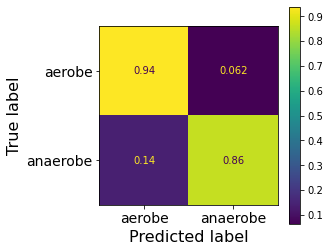

In [18]:
fig, ax = plt.subplots(figsize=(4,4))
plot_confusion_matrix(final_rf, X_test.values, actual, normalize='true', ax=ax)
plt.tick_params(labelsize=14)
ax.set_ylabel('True label', fontsize=16)
ax.set_xlabel('Predicted label', fontsize=16)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/supplementary_figures/oxygen_confusion_matrix.png',
            dpi=400, bbox_inches='tight')

### AUC plot

In [19]:
from sklearn import metrics

In [44]:
test_probabilities

,probability_aerobe,probability_anaerobe
genome,,
RS_GCF_900100045.1,0.946032,0.053968
RS_GCF_900101865.1,0.965121,0.034879
RS_GCF_014652135.1,0.979181,0.020819
RS_GCF_008806325.1,0.964572,0.035428
RS_GCF_002104765.1,0.639869,0.360131
...,...,...
RS_GCF_000008685.2,0.011993,0.988007
RS_GCF_000196795.1,0.992645,0.007355
RS_GCF_000706765.1,0.038795,0.961205


In [54]:
predicted_proba = final_rf.predict_proba(X_test.values)

fpr, tpr, _ = metrics.roc_curve(actual.values,  predicted_proba[:, 0], pos_label='aerobe')
auc = metrics.roc_auc_score(actual.values, predicted_proba[:, 1])

print(auc)

0.9691319005478297


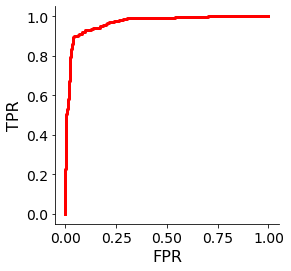

In [61]:
fig, ax = plt.subplots(figsize=(4,4))
plt.plot(fpr, tpr, label="data 1, auc="+str(auc), linewidth=3, color='r')
ax.set_ylabel('TPR', fontsize=16)
ax.set_xlabel('FPR', fontsize=16)

sns.despine()
plt.tick_params(labelsize=14)
plt.show()

### SF2 - plot of original labels

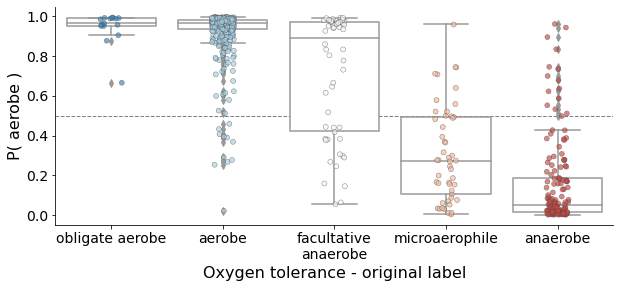

In [64]:
order = ['obligate aerobe', 'aerobe', 'facultative anaerobe', 'microaerophile', 'anaerobe']
fig, ax = plt.subplots(figsize=(10,4 ))
x_data = response_data_grouped.set_index('genome').reindex(y_final_test['genome'])['oxygen_tolerance']
sns.stripplot(y=test_probabilities['probability_aerobe'], 
             x=x_data,
            order=order, palette='RdBu_r', alpha=0.65, linewidth=0.5)
sns.boxplot(y=test_probabilities['probability_aerobe'], 
             x=x_data,
            order=order, color='white')

plt.tick_params(labelsize=14)
# plt.tick_params(rotation=90, axis='x')
ax.axhline(0.5, ls='--', zorder=0, color='gray', linewidth=1)
xticklabels = ax.set_xticklabels(['obligate aerobe', 'aerobe', 'facultative\nanaerobe', 'microaerophile', 'anaerobe'])
ax.set_ylabel('P( aerobe )', fontsize=16)
ax.set_xlabel('Oxygen tolerance - original label', fontsize=16)
sns.despine()
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/supplementary_figures/oxygen_original_labels_plot.png', bbox_inches='tight', dpi=400)

### SF3 - Plot of feature importances

In [88]:
genome_list = list(y_train['genome']) + list(y_final_test['genome'])
label_list = list(y_train['mapped_oxygen_tolerance']) + list(y_final_test['mapped_oxygen_tolerance'])

In [89]:
full_data = all_pfam_data.reindex(index=genome_list, columns=final_selected_predictors)

In [99]:
prevalence_aerobes = (full_data[np.array(label_list) == 'aerobe'] > 0).sum() / (np.array(label_list) == 'aerobe').sum()
prevalence_anaerobes = (full_data[np.array(label_list) == 'anaerobe'] > 0).sum() / (np.array(label_list) == 'anaerobe').sum()

In [102]:
feature_importances = pd.Series(index=final_selected_predictors, data=final_rf.feature_importances_)

In [111]:
pfam_data = pd.read_csv('/data/mhoffert/db/pfam/pfamA.txt.gz', sep='\t', header=None, index_col=0)[3]

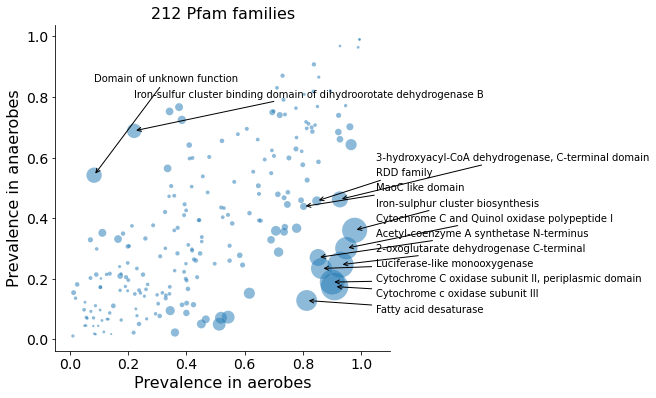

In [161]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(x=prevalence_aerobes, y=prevalence_anaerobes, 
           linewidth=0, alpha=0.5, s=feature_importances * 10000)

ax.set_xlabel('Prevalence in aerobes', fontsize=16)
ax.set_ylabel('Prevalence in anaerobes', fontsize=16)

# lgd = ax.legend()
plt.tick_params(labelsize=14)
ax.set_title('212 Pfam families', fontsize=16)
to_annotate = pfam_data.loc[prevalence_anaerobes[(prevalence_aerobes > 0.8) & (prevalence_anaerobes < 0.5)].sort_values(ascending=False).index]
shift=0
for index, val in to_annotate.iteritems():
    ax.annotate(xy=(prevalence_aerobes.loc[index],
                    prevalence_anaerobes.loc[index]),
                xytext=(1.05, 0.6+shift), xycoords ='data', textcoords='data',
                text=f'{val}', arrowprops={'arrowstyle':'->'},
                ha='left', va='center')
    shift -= 0.05
    
to_annotate = pfam_data.loc[prevalence_aerobes[(prevalence_aerobes < 0.3) & (prevalence_anaerobes > 0.5)].index]
shift = 0
for index, val in to_annotate.iteritems():
    texts.append(ax.annotate(xy=(prevalence_aerobes.loc[index],
                    prevalence_anaerobes.loc[index]),
                xytext=(prevalence_aerobes.loc[index], 0.8+shift), 
                text=f'{val}', arrowprops={'arrowstyle':'->'}))
    shift += 0.05
ax.set_xlim(-0.05, 1.1)
sns.despine()
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/supplementary_figures/oxygen_pfam_prevalence.png', dpi=400,
           bbox_inches='tight')

### Predictions on some test species

In [27]:
all_predictions = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_oxygen_predictions.tsv.gz',
                             sep='\t', index_col=0)

In [36]:
species = ['Clostridium_Q symbiosum',
'Anaerostipes caccae',
'Ruminococcus_B gnavus',
'Roseburia intestinalis',
'hallii',
'Blautia_A obeum',
'Faecalibacterium prausnitzii']
for s in species:
    print('Query: ',s)
    s_list = gtdb_md[gtdb_md.gtdb_taxonomy.str.contains(s) & gtdb_md.gtdb_representative.eq('t')]
    for index, s_ in s_list.iterrows():
        print('Match: ', s_['gtdb_taxonomy'].split(';')[-1])
        print('Probability: ',all_predictions.loc[index, 'aerobe'])
    print()

Query:  Clostridium_Q symbiosum
Match:  s__Clostridium_Q symbiosum
Probability:  0.0018285356009802

Query:  Anaerostipes caccae
Match:  s__Anaerostipes caccae
Probability:  0.0039007663333888

Query:  Ruminococcus_B gnavus
Match:  s__Ruminococcus_B gnavus
Probability:  0.0058755543272556

Query:  Roseburia intestinalis
Match:  s__Roseburia intestinalis
Probability:  0.0266409027903132

Query:  hallii
Match:  s__Anaerobutyricum hallii
Probability:  0.0008203816097187

Query:  Blautia_A obeum
Match:  s__Blautia_A obeum
Probability:  0.0011750011620159
Match:  s__Blautia_A obeum_B
Probability:  0.0018333948349246

Query:  Faecalibacterium prausnitzii
Match:  s__Faecalibacterium prausnitzii_D
Probability:  0.0042202100168366
Match:  s__Faecalibacterium prausnitzii_M
Probability:  0.0187738939262641
Match:  s__Faecalibacterium prausnitzii_L
Probability:  0.076253029728686
Match:  s__Faecalibacterium prausnitzii_F
Probability:  0.0110517407294319
Match:  s__Faecalibacterium prausnitzii_J
Pr

In [26]:
all_predictions #
#s_list

,Unnamed: 0,aerobe,anaerobe
0,RS_GCF_001457635.1,0.045539,0.954461
1,RS_GCF_003697165.2,0.993503,0.006497
2,RS_GCF_000742135.1,0.995778,0.004222
3,RS_GCF_000006945.2,0.988931,0.011069
4,RS_GCF_001027105.1,0.975919,0.024081
...,...,...,...
62286,GB_GCA_910579215.1,0.182868,0.817132
62287,GB_GCA_902587735.1,0.753537,0.246463
62288,RS_GCF_000296815.2,0.994681,0.005319
62289,GB_GCA_015055975.1,0.006172,0.993828


In [19]:
sorted(gtdb_md[gtdb_md.gtdb_taxonomy.str.contains('Clostridium')].gtdb_taxonomy.apply(lambda x: x.split(';')[-1]).unique())

['s__Clostridium baratii',
 's__Clostridium beijerinckii',
 's__Clostridium beijerinckii_A',
 's__Clostridium beijerinckii_D',
 's__Clostridium botulinum_A',
 's__Clostridium butyricum',
 's__Clostridium butyricum_A',
 's__Clostridium butyricum_B',
 's__Clostridium cagae',
 's__Clostridium celatum',
 's__Clostridium chauvoei',
 's__Clostridium chromiireducens',
 's__Clostridium cuniculi',
 's__Clostridium disporicum',
 's__Clostridium gasigenes',
 's__Clostridium isatidis',
 's__Clostridium moniliforme',
 's__Clostridium neonatale',
 's__Clostridium nigeriense',
 's__Clostridium paraputrificum',
 's__Clostridium puniceum',
 's__Clostridium saccharobutylicum',
 's__Clostridium saccharoperbutylacetonicum',
 's__Clostridium sardiniense',
 's__Clostridium sartagoforme_A',
 's__Clostridium sartagoforme_B',
 's__Clostridium saudiense',
 's__Clostridium septicum',
 's__Clostridium sp000230835',
 's__Clostridium sp000435835',
 's__Clostridium sp000498355',
 's__Clostridium sp000753455',
 's__C